# Feasibility study

In our feasibility study we want to test if the sensor value distributions are different for pairwise combinations of holds, while also inspecting the differences of distributions for the same holds but in different people.

To do this, we first import libraries and the data we recorded for the feasibility study on April 23.

In [1]:
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import ks_2samp
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from script.helpers import get_data
from script.visualization import pretty_hm, pretty_str, savefig_pdf

In [2]:
X, y = get_data(dates=['0423'])
hold_types = pd.Categorical(y.hold).categories
people = pd.Categorical(y.name).categories

## Dimensionality reduction

Our dataset is eight-dimensional but we need to conduct our hypothesis testing on one-dimensional data.
To take all eight sensors into account instead of just selecting one, we test along the axis of highest variance, i.e. the first principal component.

Note that we fit the Principal Component Analysis to only the data where a hold was being held by omitting all idle data points.

In [3]:
pca = PCA(n_components=1)
pca.fit(X[(y.hold != 'idle')])
X['PCA1'] = pca.transform(X)

Now that we have computed reduced one-dimensional data, we can look at histograms for the different holds for all participants.

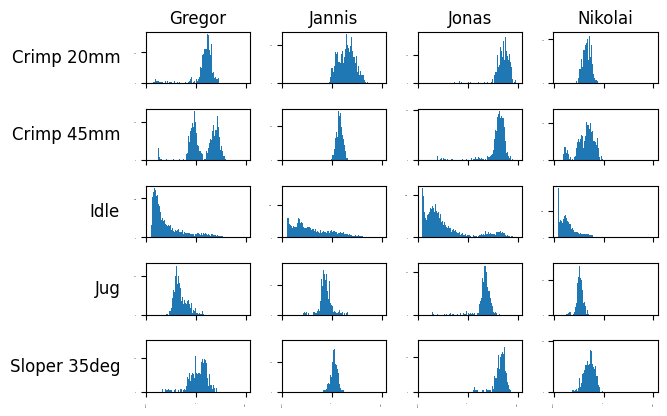

In [4]:
axes = X.PCA1.hist(by=[y.hold, y.name], bins=100, xlabelsize=0, ylabelsize=0, sharex=True)

for ax, (hold, name) in zip(axes.flatten(), [(h, n) for h in hold_types for n in people]):
    row, col = list(hold_types).index(hold), list(people).index(name)
    ax.set_title(f'{pretty_str(name)}' if row == 0 else '', fontsize=12)
    if col == 0:
        ax.annotate(f'{pretty_str(hold)}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 2, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=12, rotation=0)

savefig_pdf('pca-distributions')

Here, we see that we cannot assume a normal distribution in all of our data, which is why we opt for the non-parametric Kolmogorov-Smirnov test in the following.

## Testing

We conduct a two-sided Kolmogorov-Smirnov test for all pairs of distributions seen above, i.e. each combination of `(hold/idle, person)` (HPC) against each other one.
Therefore, our null-hypothesis for each test is that the data for the two HPCs originates from the same underlying distribution.

With the final goal being to predict hold types independent of the person, our desired result is to reject all HPCs where the holds are different, and fail to reject all where the holds are the same.

We want to test our hypotheses with a confidence level of 95%.
Since we are testing multiple hypotheses, i.e. one for each pair of HPCs, we have to account for the multiple comparisons problem.
We do this by applying a Bonferroni Correction and dividing our rejection threshold by the number of tests we will conduct.

In [5]:
hpcs = np.array(np.meshgrid(hold_types, people)).T.reshape((len(hold_types) * len(people), 2))

alpha = 0.95
threshold = (1 - alpha) / binom(len(hpcs), 2)
print('Bonferroni-corrected rejection threshold:')
print(f'  p < {threshold:.4f}  ⇔  -log(p) > {-np.log(threshold):.2f}')

Bonferroni-corrected rejection threshold:
  p < 0.0003  ⇔  -log(p) > 8.24


In [6]:
results = np.ones((len(hpcs), len(hpcs)))
desired_rejection = np.ones((len(hpcs), len(hpcs)))
for i, (hold1, name1) in enumerate(hpcs):
    for j, (hold2, name2) in enumerate(hpcs):
        if i <= j: continue
        results[i, j] = ks_2samp(
            X.PCA1[(y.hold == hold1) & (y.name == name1)],
            X.PCA1[(y.hold == hold2) & (y.name == name2)]).pvalue
        desired_rejection[i, j] = 0 if hold1 == hold2 else 1

We visualize the testing results as a heatmap of the negative logarithm of the p-value, i.e. the negative logarithm of the probability that the data of the given combination was drawn from the same underlying distribution.

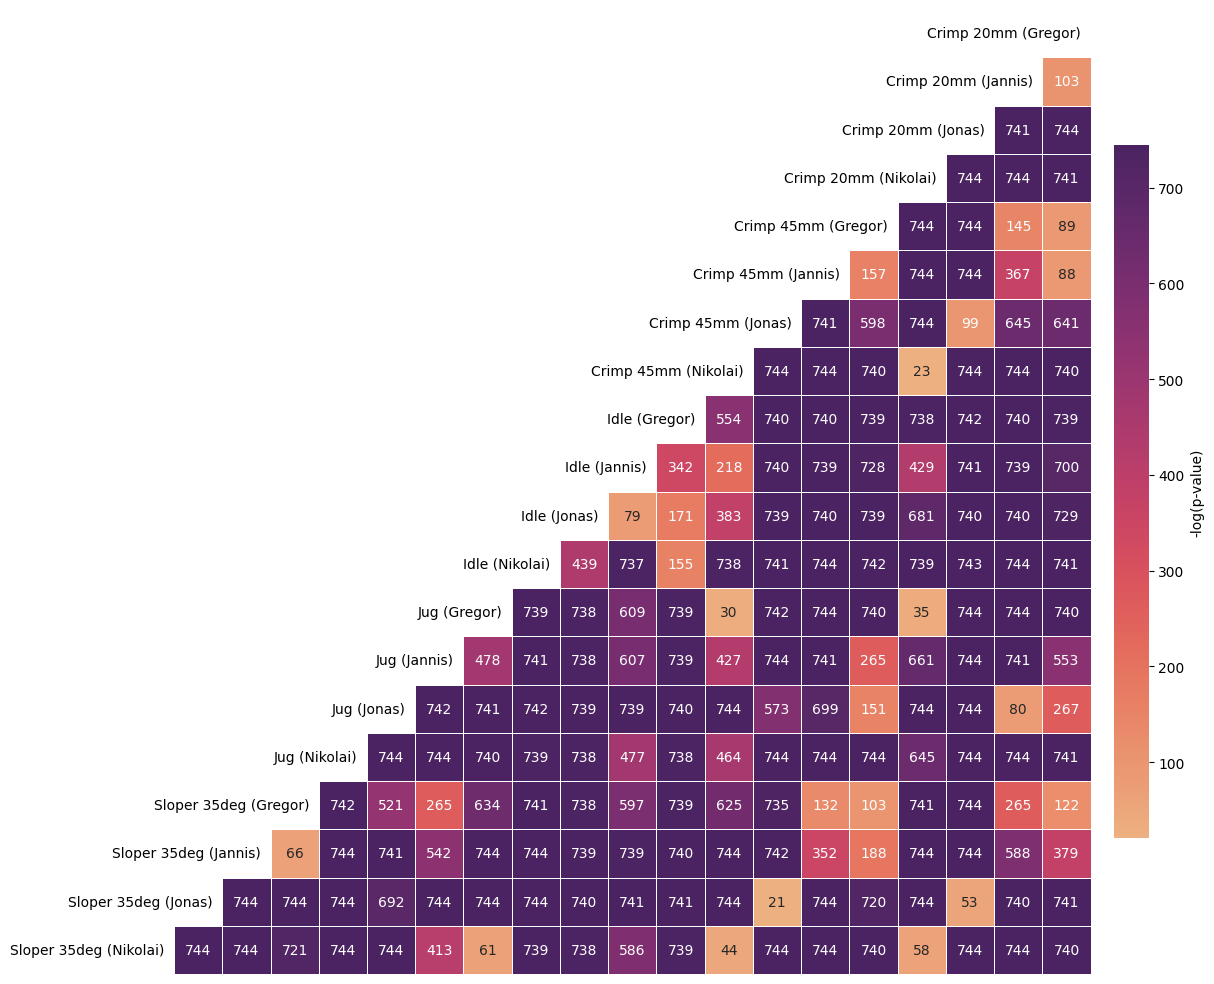

In [7]:
plt.subplots(figsize=(15, 15))
labels = [f'{pretty_str(hold)} ({pretty_str(name)})' for hold, name in hpcs]
pretty_hm(results, labels)
savefig_pdf('pairwise-ks')

We can see that all pairs HPCs have very small p-values which are rejected at our computed threshold. This means we reject all hypotheses and have shown that all pairs HPCs produce data from significantly different distributions.

While this hints that we will be able to predict the hold type for a single selected person, it also indicates that the patterns of holding the same hold do not generalize across multiple people.
As mentioned before, the desired result where the patterns do generalize across multiple people, would have been to not reject the hypotheses where the holds are the same, as seen in the following figure.

Desired rejection pattern where 1 is rejection and 0 is fail to reject


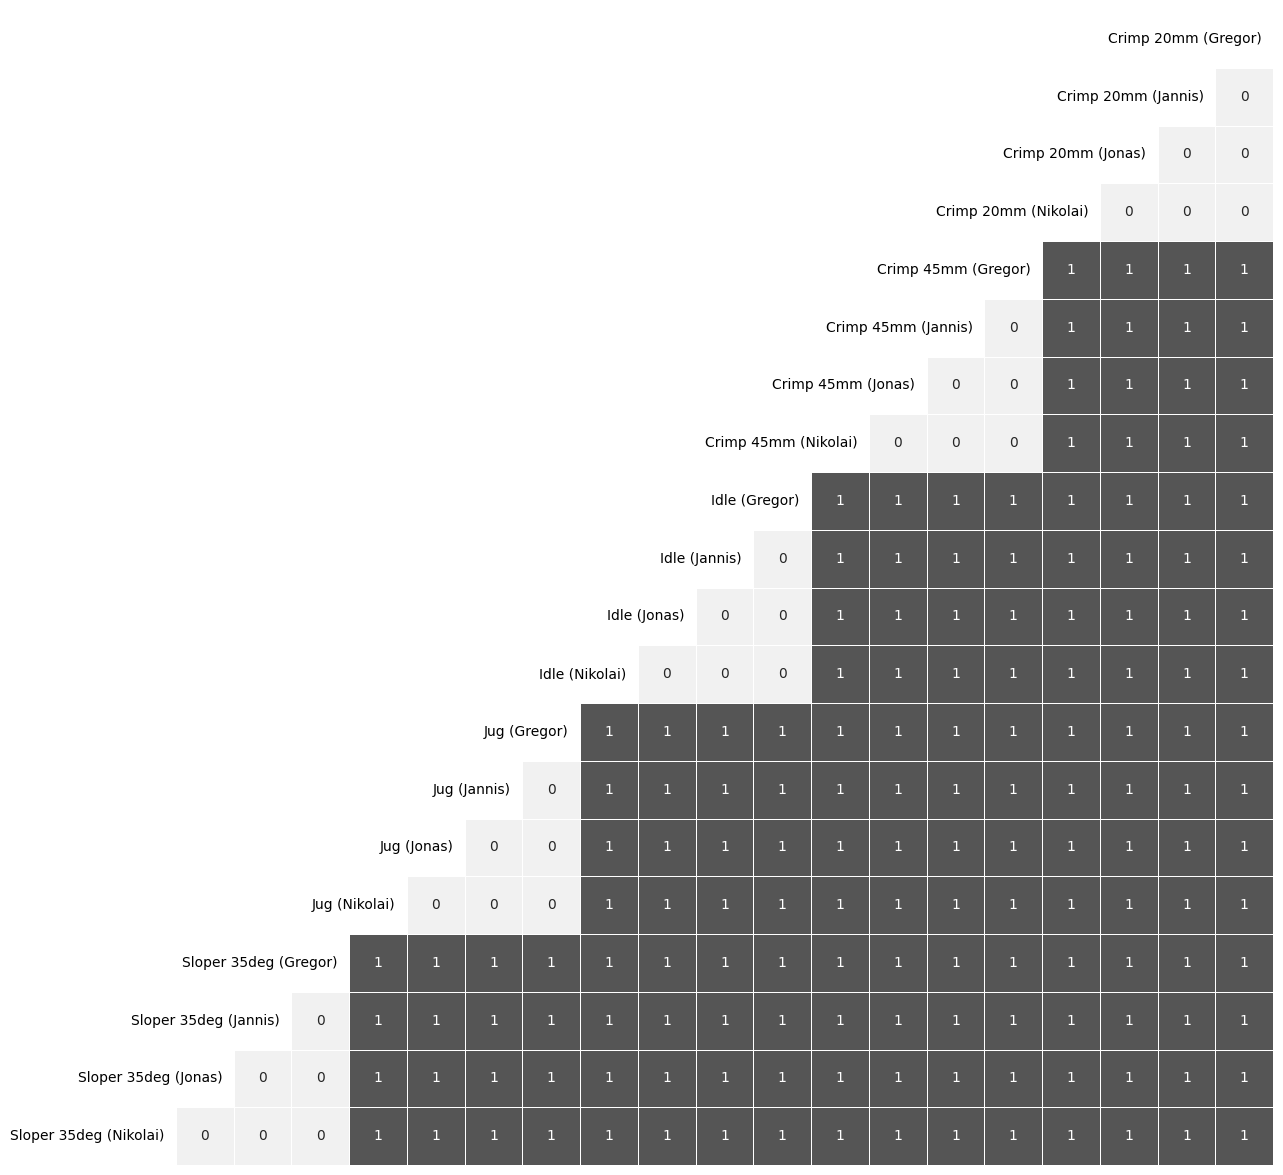

In [8]:
plt.subplots(figsize=(15, 15))
pretty_hm(desired_rejection, labels, legend=False, transform=None, cmap=sns.color_palette("light:#555", as_cmap=True))
savefig_pdf('desired-rejection')
print('Desired rejection pattern where 1 is rejection and 0 is fail to reject')